Task: develop a model that predicts a probability of default on a purchase made with Pay Later

This notebook explores the data to form insights about features

* Inputs: mlcasestudy.csv

Contents:
1. Load and prepare data
2. Inspect missing values
3. Explore data

In [405]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import shap
import xgboost as xgb


from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder


In [406]:
def create_features(df):
    # Create a missingness flag for existing_klarna_debt
    df['existing_debt_missing'] = df['existing_klarna_debt'].isnull().astype(int)

    # Replace missing values for existing_klarna_debt with 0
    df['existing_klarna_debt'] = df['existing_klarna_debt'].fillna(0)

    # Create a missingness flag for card expiry date
    df['card_expiry_missing'] = df['card_expiry_month'].isnull().astype(int)

     # Loan_to_debt_ratio
    df['loan_to_debt_ratio'] = df['loan_amount'] / (df['existing_klarna_debt'] + df['loan_amount'])

    # New_exposure_7d_to_debt
    df['new_exposure_7d_to_debt'] = df['new_exposure_7d'] / (df['existing_klarna_debt'] + df['loan_amount'])

    # New_exposure_14d_to_debt
    df['new_exposure_14d_to_debt'] = df['new_exposure_14d'] / (df['existing_klarna_debt'] + df['loan_amount'])


    # Repayment to total debt
    df['repayment_1y_to_debt'] = (df['amount_repaid_1y'] / (df['existing_klarna_debt'] + df['loan_amount']))
    df['repayment_6m_to_debt'] = (df['amount_repaid_6m'] / (df['existing_klarna_debt'] + df['loan_amount']))
    df['repayment_3m_to_debt'] = (df['amount_repaid_3m'] / (df['existing_klarna_debt'] + df['loan_amount']))
    df['repayment_1m_to_debt'] = (df['amount_repaid_1m'] / (df['existing_klarna_debt'] + df['loan_amount']))
    df['repayment_14d_to_debt'] = (df['amount_repaid_14d'] / (df['existing_klarna_debt'] + df['loan_amount']))

    

    # Repayment_rate variations
    epsilon = 1e-5  # Small constant

    # Repayment to new exposure 14d
    df['repayment_rate_to_new_14d'] = (df['amount_repaid_14d'] / (df['new_exposure_14d'] + epsilon)).astype(float)

    # Repayment to number of active loans
    df['repayment_rate_to_num'] = (df['amount_repaid_14d'] / (df['num_active_loans'] + epsilon)).astype(float)

    

    # Ratio of confirmed payments to active loans
    df['num_conf_payments_6m_to_num_loans'] = df['num_confirmed_payments_6m'] / (df['num_active_loans'] + epsilon)

    # Ratio of failed payments to active loans
    df['num_failed_payments_6m_to_num_loans'] = df['num_failed_payments_6m'] / (df['num_active_loans'] + epsilon)

     # Create number ratios
    df['num_failed_to_conf_payments_6m'] = df['num_failed_payments_6m'] / (df['num_confirmed_payments_6m'] + epsilon)

    df['num_failed_to_conf_payments_3m'] = df['num_failed_payments_3m'] / (df['num_confirmed_payments_3m'] + epsilon)


    # Merchant category and group variables 

    # Average Loans
    df['category_avg_loan'] = df.groupby('merchant_category')['loan_amount'].transform('mean')
    df['group_avg_loan'] = df.groupby('merchant_group')['loan_amount'].transform('mean')

    # Average default rates
    df['category_default_rate'] = df.groupby('merchant_category')['default'].transform('mean')
    df['group_default_rate'] = df.groupby('merchant_group')['default'].transform('mean')



    return df


In [407]:

def calculate_months_to_card_expiration(df):
    """
    Calculate card_expiry_date and months_to_card_expiration between loan_issue_date and card_expiry_date.
    """
    # Ensure loan_issue_date is datetime
    df['loan_issue_date'] = pd.to_datetime(df['loan_issue_date'], errors='coerce')

    # Combine year and month for card expiration
    df['card_expiry_date'] = pd.to_datetime(
        df.apply(
            lambda row: f"{int(row['card_expiry_year'])}-{int(row['card_expiry_month']):02d}-01"
            if pd.notna(row['card_expiry_year']) and pd.notna(row['card_expiry_month'])
            else np.nan,
            axis=1
        ), 
        errors='coerce'
    )

    # Calculate the difference in months
    df['months_to_card_expiration'] = np.where(
        df['card_expiry_date'].notna() & df['loan_issue_date'].notna(),
        (df['card_expiry_date'].dt.year - df['loan_issue_date'].dt.year) * 12 +
        (df['card_expiry_date'].dt.month - df['loan_issue_date'].dt.month),
        np.nan
    )

     # Convert month_to_card_expiration to integer
    df['months_to_card_expiration'] = df['months_to_card_expiration'].fillna(-1).astype(int).replace(-1, np.nan)

    return df


# 1. Load and prepare data

In [408]:
# Load the data
df = pd.read_csv('data/mlcasestudy.csv')
df.head()

,loan_id,loan_issue_date,loan_amount,amount_outstanding_14d,amount_outstanding_21d,card_expiry_month,card_expiry_year,existing_klarna_debt,num_active_loans,days_since_first_loan,...,num_failed_payments_3m,num_failed_payments_6m,num_failed_payments_1y,amount_repaid_14d,amount_repaid_1m,amount_repaid_3m,amount_repaid_6m,amount_repaid_1y,merchant_group,merchant_category
0,a55cf3062bd45a83766096fd0c4697d6,2023-06-24,5300,0,0,2.0,2026.0,21098.0,2,717,...,0,0,0,6875,15580,42325,67878,152193,Clothing & Shoes,Adult Shoes & Clothing
1,45e3d15cb313d767470722e952e14313,2023-09-22,9547,7161,7161,6.0,2027.0,NaN,0,-1,...,0,0,0,0,0,0,0,0,"Leisure, Sport & Hobby",Concept Stores & Miscellaneous
2,b195c127c7605b7b936b90bcdb5e889c,2023-07-03,5948,0,0,12.0,2023.0,NaN,0,-1,...,0,0,0,0,0,0,0,0,Clothing & Shoes,General Shoes & Clothing
3,36028b1dbeb4aeef565a79ca9700667a,2023-08-19,15871,11904,0,2.0,2026.0,31742.0,1,0,...,0,0,0,0,0,0,0,0,Clothing & Shoes,Youthful Shoes & Clothing
4,5317f8e22a8f790b6e11a0f12320422d,2023-09-30,19510,0,0,8.0,2026.0,9064.0,1,501,...,0,0,0,6511,14000,32289,61993,116532,"Leisure, Sport & Hobby",Sports Gear & Outdoor


## Describe dataset

In [409]:
df.shape

(111902, 24)

In [410]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111902 entries, 0 to 111901
Data columns (total 24 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   loan_id                    111902 non-null  object 
 1   loan_issue_date            111902 non-null  object 
 2   loan_amount                111902 non-null  int64  
 3   amount_outstanding_14d     111902 non-null  int64  
 4   amount_outstanding_21d     111902 non-null  int64  
 5   card_expiry_month          111747 non-null  float64
 6   card_expiry_year           111747 non-null  float64
 7   existing_klarna_debt       82690 non-null   float64
 8   num_active_loans           111902 non-null  int64  
 9   days_since_first_loan      111902 non-null  int64  
 10  new_exposure_7d            111902 non-null  int64  
 11  new_exposure_14d           111902 non-null  int64  
 12  num_confirmed_payments_3m  111902 non-null  int64  
 13  num_confirmed_payments_6m  11

In [411]:
# Number unique loan ids
df.loan_id.nunique()

111902

In [412]:
df.describe().round(1)

,loan_amount,amount_outstanding_14d,amount_outstanding_21d,card_expiry_month,card_expiry_year,existing_klarna_debt,num_active_loans,days_since_first_loan,new_exposure_7d,new_exposure_14d,num_confirmed_payments_3m,num_confirmed_payments_6m,num_failed_payments_3m,num_failed_payments_6m,num_failed_payments_1y,amount_repaid_14d,amount_repaid_1m,amount_repaid_3m,amount_repaid_6m,amount_repaid_1y
count,111902.0,111902.0,111902.0,111747.0,111747.0,82690.0,111902.0,111902.0,111902.0,111902.0,111902.0,111902.0,111902.0,111902.0,111902.0,111902.0,111902.0,111902.0,111902.0,111902.0
mean,17574.5,784.0,427.4,6.6,2026.1,16018.2,0.7,294.8,3555.8,4895.8,4.2,7.3,0.0,0.1,0.2,2579.5,5177.6,13674.3,23848.2,39059.6
std,23187.4,3870.2,3288.0,3.3,1.5,33369.8,1.4,346.8,12253.6,14762.2,8.8,15.2,0.3,0.8,1.5,6582.4,12532.8,30424.1,52617.7,85773.5
min,102.0,0.0,0.0,1.0,2023.0,-220618.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,6160.0,0.0,0.0,4.0,2025.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,10877.0,0.0,0.0,6.0,2026.0,1404.0,0.0,136.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3656.5,8436.0
75%,19461.0,0.0,0.0,9.0,2027.0,19008.0,1.0,546.0,0.0,2141.5,5.0,8.0,0.0,0.0,0.0,2490.0,5406.0,15116.5,26819.2,43523.0
max,392913.0,193313.0,193313.0,12.0,2032.0,817852.0,61.0,1095.0,562297.0,562297.0,356.0,602.0,17.0,52.0,266.0,214994.0,531469.0,1398723.0,3582917.0,6985861.0


In [413]:
df[['loan_issue_date', 'card_expiry_month', 'card_expiry_year']].head()

,loan_issue_date,card_expiry_month,card_expiry_year
0,2023-06-24,2.0,2026.0
1,2023-09-22,6.0,2027.0
2,2023-07-03,12.0,2023.0
3,2023-08-19,2.0,2026.0
4,2023-09-30,8.0,2026.0


In [414]:
print(f"Earliest loan issue date: {df['loan_issue_date'].min()}")
print(f"Latest loan issue date: {df['loan_issue_date'].max()}")


Earliest loan issue date: 2023-06-01
Latest loan issue date: 2023-10-27


## Define target variable

Describe amount outstanding

In [415]:
# Describe amount outstanding
df[['amount_outstanding_14d', 'amount_outstanding_21d']].describe().round(2)

,amount_outstanding_14d,amount_outstanding_21d
count,111902.00,111902.00
mean,783.98,427.41
std,3870.22,3287.97
min,0.00,0.00
25%,0.00,0.00
50%,0.00,0.00
75%,0.00,0.00
max,193313.00,193313.00


In [416]:
# Share of loans with non-zero amount outstanding after 14 days
share_nonzero_outstanding_14d = len(df[df.amount_outstanding_14d > 0])/(len(df))*100
print(f'Share with non-zero amount outstanding after 14 days: {share_nonzero_outstanding_14d:.2f}%')


Share with non-zero amount outstanding after 14 days: 12.87%


In [417]:
# Share of loans with non-zero amount outstanding after 21 days
share_nonzero_outstanding_21d = len(df[df.amount_outstanding_21d > 0])/(len(df))*100
print(f'Share with non-zero amount outstanding after 21 days: {share_nonzero_outstanding_21d:.2f}%')

Share with non-zero amount outstanding after 21 days: 5.44%


Define target variable

In [418]:
# Target variable
df['default'] = (df.amount_outstanding_21d > 0).astype(int)

In [419]:
# Default incidence
df.default.value_counts(normalize=True).round(3)

default
0    0.946
1    0.054
Name: proportion, dtype: float64

# 2. Inspect missing values

In [420]:
# Which columns have missing values?
df.isnull().sum()   

loan_id                          0
loan_issue_date                  0
loan_amount                      0
amount_outstanding_14d           0
amount_outstanding_21d           0
card_expiry_month              155
card_expiry_year               155
existing_klarna_debt         29212
num_active_loans                 0
days_since_first_loan            0
new_exposure_7d                  0
new_exposure_14d                 0
num_confirmed_payments_3m        0
num_confirmed_payments_6m        0
num_failed_payments_3m           0
num_failed_payments_6m           0
num_failed_payments_1y           0
amount_repaid_14d                0
amount_repaid_1m                 0
amount_repaid_3m                 0
amount_repaid_6m                 0
amount_repaid_1y                 0
merchant_group                   0
merchant_category                0
default                          0
dtype: int64

#### Explore missing `existing_klarna_debt`

In [421]:
# Compare the distribution of features for missing and non-missing existing_klarna_debt
df_missing = df[df['existing_klarna_debt'].isnull()]
df_not_missing = df[df['existing_klarna_debt'].notnull()]

# Define numerical columns
numerical_columns = df.select_dtypes(include='number').columns


# Calculate mean and std for both groups (restrict to numeric_features)
mean_missing = df_missing[numerical_columns].mean()
std_missing = df_missing[numerical_columns].std()

mean_not_missing = df_not_missing[numerical_columns].mean()
std_not_missing = df_not_missing[numerical_columns].std()

# Combine into a single table
comparison = pd.DataFrame({
    'Mean_m': mean_missing.round(1),
    'Std_m': std_missing.round(1),
    'Mean_nonm': mean_not_missing.round(1),
    'Std_nonm': std_not_missing.round(1)
})

# Display the comparison table
print("Numerical values for Missing and Non-missing existing_klarna_debt:")
print(comparison)


Numerical values for Missing and Non-missing existing_klarna_debt:
                            Mean_m    Std_m  Mean_nonm  Std_nonm
loan_amount                24273.7  32207.2    15207.8   18430.9
amount_outstanding_14d      1017.3   5016.5      701.5    3369.6
amount_outstanding_21d       576.9   4300.4      374.6    2843.6
card_expiry_month              6.7      3.4        6.5       3.3
card_expiry_year            2026.2      1.6     2026.0       1.5
existing_klarna_debt           NaN      NaN    16018.2   33369.8
num_active_loans               0.0      0.0        0.9       1.6
days_since_first_loan         -1.0      2.5      399.4     347.7
new_exposure_7d                9.6    790.8     4808.6   14034.3
new_exposure_14d               9.6    790.8     6622.0   16830.7
num_confirmed_payments_3m      0.0      0.0        5.7       9.8
num_confirmed_payments_6m      0.0      0.0        9.9      17.0
num_failed_payments_3m         0.0      0.0        0.0       0.4
num_failed_payments_6m 

In [422]:
df[df['existing_klarna_debt'].isnull()].days_since_first_loan.value_counts(normalize=True)

days_since_first_loan
-1      0.999384
 0      0.000479
 1      0.000068
 413    0.000034
 121    0.000034
Name: proportion, dtype: float64

#### Explore missing `card_expiry_month` and `card_expiry_year`

In [423]:
df[df.card_expiry_month.isnull()].head()

,loan_id,loan_issue_date,loan_amount,amount_outstanding_14d,amount_outstanding_21d,card_expiry_month,card_expiry_year,existing_klarna_debt,num_active_loans,days_since_first_loan,...,num_failed_payments_6m,num_failed_payments_1y,amount_repaid_14d,amount_repaid_1m,amount_repaid_3m,amount_repaid_6m,amount_repaid_1y,merchant_group,merchant_category,default
1546,f602c8882bdb905b905d0be81e5d8455,2023-07-12,39930,0,0,NaN,NaN,0.0,0,675,...,0,0,0,34095,68211,102327,170559,Home & Garden,Kitchenware,0
1955,983bea05a888f6921dc19a253e1e22c2,2023-07-19,15262,3816,0,NaN,NaN,0.0,0,478,...,0,0,0,0,16592,18780,43471,Clothing & Shoes,General Shoes & Clothing,0
1973,f6fdf0bb5427187c2f6b0d1661dac697,2023-06-16,7757,1940,0,NaN,NaN,10028.0,1,866,...,0,0,0,0,4506,9011,27524,Clothing & Shoes,Youthful Shoes & Clothing,0
2002,34cc3124e842f757797a43da0f897c7e,2023-07-14,33355,8339,0,NaN,NaN,0.0,0,948,...,0,0,0,0,0,0,0,Clothing & Shoes,Youthful Shoes & Clothing,0
3223,db7fc733fab7ca64bece489827fb4097,2023-09-23,11573,1929,0,NaN,NaN,0.0,0,-1,...,0,0,0,0,0,0,0,Electronics,Diversified Electronics,0


In [424]:
# Verify if both card_expiry_month and card_expiry_year are missing for the same rows by checking the number of rows where both are missing
len(df[(df.card_expiry_month.isnull()) & (df.card_expiry_year.isnull())])

155

In [425]:
# Check max and min loan issue date for missing card_expiry_month
print(f"Earliest loan issue date when card exiry missing: {df[df.card_expiry_month.isnull()]['loan_issue_date'].min()}")
print(f"Latest loan issue date when card exiry missing: {df[df.card_expiry_month.isnull()]['loan_issue_date'].max()}")

Earliest loan issue date when card exiry missing: 2023-06-01
Latest loan issue date when card exiry missing: 2023-10-24


In [426]:
# Compare the distribution of features for missing and non-missing existing_klarna_debt
df_missing = df[df['card_expiry_month'].isnull()]
df_not_missing = df[df['card_expiry_month'].notnull()]


# Calculate mean and std for both groups (restrict to numeric_features)
mean_missing = df_missing[numerical_columns].mean()
std_missing = df_missing[numerical_columns].std()

mean_not_missing = df_not_missing[numerical_columns].mean()
std_not_missing = df_not_missing[numerical_columns].std()

# Combine into a single table
comparison = pd.DataFrame({
    'Mean_m': mean_missing.round(1),
    'Std_m': std_missing.round(1),
    'Mean_nonm': mean_not_missing.round(1),
    'Std_nonm': std_not_missing.round(1)
})

# Display the comparison table
print("Comparison of features for Missing and Non-missing card_expiry_month & card_expiry_year:")
print(comparison)


Comparison of features for Missing and Non-missing card_expiry_month & card_expiry_year:
                            Mean_m     Std_m  Mean_nonm  Std_nonm
loan_amount                16552.2   16345.9    17575.9   23195.5
amount_outstanding_14d      4397.5    6749.6      779.0    3862.4
amount_outstanding_21d      1493.2    6217.9      425.9    3281.9
card_expiry_month              NaN       NaN        6.6       3.3
card_expiry_year               NaN       NaN     2026.1       1.5
existing_klarna_debt       20093.0   44207.0    16010.8   33346.6
num_active_loans               1.3       3.0        0.7       1.4
days_since_first_loan        548.4     331.4      294.5     346.7
new_exposure_7d             4083.2    9352.4     3555.1   12257.1
new_exposure_14d            6661.6   15416.4     4893.4   14761.2
num_confirmed_payments_3m      7.1      14.8        4.2       8.8
num_confirmed_payments_6m     12.6      25.2        7.3      15.2
num_failed_payments_3m         0.0       0.0        0

### Insights on Missing Values

**Missing existing_klarna_debt:**
- `num_active_loans` is always 0.
- All `num_confirmed_payments_*`, `num_failed_payments_*`, and `amount_repaid_*` fields are 0.
- 99% of these observations have `days_since_first_loan` set to -1.

This suggests that `existing_klarna_debt` is missing primarily for customers with no prior history, indicating they are likely new customers.

**Missing card_expiry_month and card_expiry_year:**
- Variables such as `existing_klarna_debt`, `num_active_loans`, and `num_failed_payments_1y` show significant differences when `card_expiry_date` is missing.

---

### Modeling Decisions

**For existing_klarna_debt:**
1. Test imputing `existing_klarna_debt` with 0 and introducing an indicator variable to flag missing values.
2. Compare this approach to leaving the variable as-is.

Preliminary analysis suggests that the missingness indicator could serve as a proxy for identifying new customers.

**For card_expiry_month and card_expiry_year:**
1. Test introducing an indicator variable to flag missing values and evaluate its predictive value.

---

**Note:** In a real-world scenario, I would consult with the team responsible for these features to ensure the proposed approach aligns with their domain knowledge.


# 3. Explore data

## Split data

In [427]:
# Splitting the data into train, validation and test sets
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=42)

In [428]:
# print shapes
print(df_train.shape, df_val.shape, df_test.shape)

(67140, 25) (22381, 25) (22381, 25)


Check default incidence in the splitted data

In [429]:
df_train.default.value_counts(normalize=True)

default
0    0.946559
1    0.053441
Name: proportion, dtype: float64

In [430]:
df_val.default.value_counts(normalize=True)

default
0    0.943747
1    0.056253
Name: proportion, dtype: float64

In [431]:
df_test.default.value_counts(normalize=True)

default
0    0.944507
1    0.055493
Name: proportion, dtype: float64

In [432]:
# reset index
df_train = df_train.reset_index(drop=True)

In [433]:
# Add features
df_train = create_features(df_train)

In [434]:
# Add column: months to card expiration
df_train = calculate_months_to_card_expiration(df_train)

## Prepare feature list

In [435]:
# Define list of columns that won't be used in the model
helper_columns = ['amount_outstanding_14d', 'amount_outstanding_21d', 
                  'card_expiry_month', 'card_expiry_year','card_expiry_date', 'loan_id', 'loan_issue_date']

# Extract categorical and numerical columns
categorical_features_eda = df_train.select_dtypes(include='object').columns.difference(helper_columns).tolist()
numerical_features_eda = df_train.select_dtypes(exclude='object').columns.difference(helper_columns + ['default']).tolist()


# Print categorical features 
print("\nCategorical features to explore:\n")
print("\n".join(categorical_features_eda))

# Print numerical features 
print("\nNumerical features to explore:\n")
print("\n".join(numerical_features_eda))




Categorical features to explore:

merchant_category
merchant_group

Numerical features to explore:

amount_repaid_14d
amount_repaid_1m
amount_repaid_1y
amount_repaid_3m
amount_repaid_6m
card_expiry_missing
category_avg_loan
category_default_rate
days_since_first_loan
existing_debt_missing
existing_klarna_debt
group_avg_loan
group_default_rate
loan_amount
loan_to_debt_ratio
months_to_card_expiration
new_exposure_14d
new_exposure_14d_to_debt
new_exposure_7d
new_exposure_7d_to_debt
num_active_loans
num_conf_payments_6m_to_num_loans
num_confirmed_payments_3m
num_confirmed_payments_6m
num_failed_payments_1y
num_failed_payments_3m
num_failed_payments_6m
num_failed_payments_6m_to_num_loans
num_failed_to_conf_payments_3m
num_failed_to_conf_payments_6m
repayment_14d_to_debt
repayment_1m_to_debt
repayment_1y_to_debt
repayment_3m_to_debt
repayment_6m_to_debt
repayment_consistency
repayment_rate_to_new_14d
repayment_rate_to_num


In [436]:
# Get the top n merchant categories by count
n = 10

# Merchant categories
top_n_categories = df_train['merchant_category'].value_counts().nlargest(n).index

# Merchant groups
top_n_groups = df_train['merchant_group'].value_counts().nlargest(n).index

# Reassign categories outside the top n and 'Unknown' to 'else'
df_train['merchant_category'] = df_train['merchant_category'].apply(
    lambda x: 'Other' if x not in top_n_categories or x == 'Unknown' else x
)

# Reassign groups outside the top n and 'Unknown' to 'else'
df_train['merchant_group'] = df_train['merchant_group'].apply(
    lambda x: 'Other' if x not in top_n_groups or x == 'Unknown' else x
)



# EDA

In [437]:
# Are there any duplicated rows?
df_train.duplicated(subset=None).sum()


np.int64(0)

In [438]:
# Baseline default rate
global_default_rate = df_train.default.mean()
print(f'Global default rate: {global_default_rate:.2f}')

Global default rate: 0.05


## Explore categorical features

In [439]:
df_train[categorical_features_eda].nunique()

merchant_category    11
merchant_group       10
dtype: int64

In [440]:
df_train.merchant_group.value_counts()

merchant_group
Clothing & Shoes          38766
Intangible products        9455
Leisure, Sport & Hobby     5698
Jewelry & Accessories      4836
Home & Garden              2467
Health & Beauty            2172
Electronics                1303
Food & Beverage            1215
Other                      1021
Children Products           207
Name: count, dtype: int64

In [441]:
df_train.merchant_category.value_counts()

merchant_category
General Shoes & Clothing             22731
Youthful Shoes & Clothing            10513
Other                                 9404
Adult Shoes & Clothing                5492
Event - Broker & Agencies             3914
Travel - Accommodation & Resorts      3817
Diversified Jewelry & Accessories     3695
Concept Stores & Miscellaneous        2742
Sports Gear & Outdoor                 2613
Food & Beverage                       1193
Furniture                             1026
Name: count, dtype: int64

In [442]:
# Inspect outcome for each categorical column
merchant_features = ['merchant_group', 'merchant_category']

for c in merchant_features:
    print(c)
    df_group = df_train.groupby(c).default.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_default_rate
    df_group['risk'] = df_group['mean'] / global_default_rate #higher-than-average default risk?

    display(df_group.sort_values(by='count', ascending=False))
    print()
    print()

merchant_group


,mean,count,diff,risk
merchant_group,,,,
Clothing & Shoes,0.057138,38766,0.003697,1.069182
Intangible products,0.060603,9455,0.007162,1.134023
"Leisure, Sport & Hobby",0.035627,5698,-0.017814,0.666657
Jewelry & Accessories,0.038048,4836,-0.015393,0.711968
Home & Garden,0.041751,2467,-0.011689,0.781262
Health & Beauty,0.052947,2172,-0.000494,0.990756
Electronics,0.044513,1303,-0.008928,0.832938
Food & Beverage,0.072428,1215,0.018987,1.355300
Other,0.040157,1021,-0.013284,0.751427




merchant_category


,mean,count,diff,risk
merchant_category,,,,
General Shoes & Clothing,0.050372,22731,-0.003069,0.942575
Youthful Shoes & Clothing,0.080186,10513,0.026746,1.500479
Other,0.049872,9404,-0.003568,0.933231
Adult Shoes & Clothing,0.041151,5492,-0.012290,0.770029
Event - Broker & Agencies,0.045478,3914,-0.007963,0.850997
Travel - Accommodation & Resorts,0.072046,3817,0.018606,1.348154
Diversified Jewelry & Accessories,0.033829,3695,-0.019611,0.633030
Concept Stores & Miscellaneous,0.036470,2742,-0.016971,0.682435
Sports Gear & Outdoor,0.036357,2613,-0.017084,0.680320


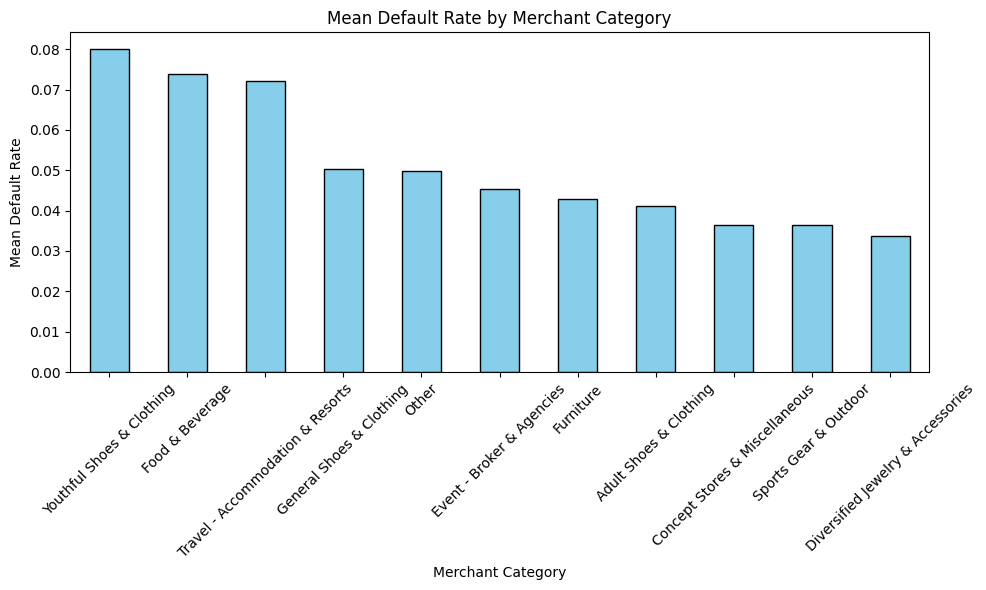

In [443]:


#  Calculate mean default by merchant_category
mean_default = df_train.groupby('merchant_category')['default'].mean().sort_values(ascending=False)

# Plot 
plt.figure(figsize=(10, 6))
mean_default.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Mean Default Rate by Merchant Category')
plt.ylabel('Mean Default Rate')
plt.xlabel('Merchant Category')
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()


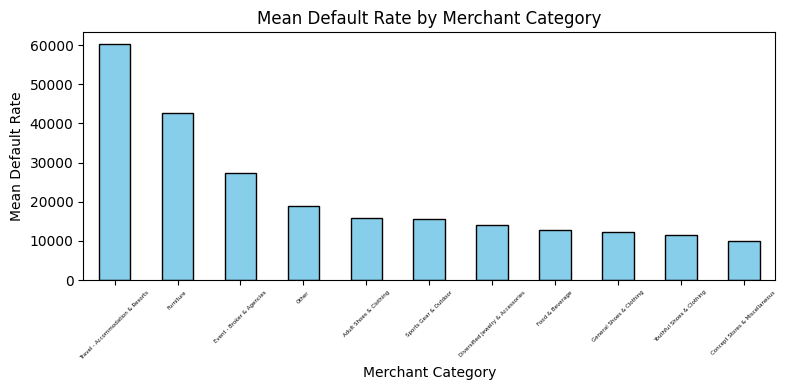

In [444]:
# Calculate mean default by merchant_category
mean_default = df_train.groupby('merchant_category')['loan_amount'].mean().sort_values(ascending=False)

# Plot with adjusted figure size and label font size
plt.figure(figsize=(8, 4))  # Smaller figure size
mean_default.plot(kind='bar', color='skyblue', edgecolor='black')

# Add titles and labels
plt.title('Mean Default Rate by Merchant Category', fontsize=12)  # Adjust title font size
plt.ylabel('Mean Default Rate', fontsize=10)
plt.xlabel('Merchant Category', fontsize=10)

# Adjust x-axis label size
plt.xticks(rotation=45, fontsize=4)  # Smaller x-axis labels
plt.tight_layout()
plt.show()


In [445]:
# Describe merchant variables
df_train[['category_avg_loan', 'group_avg_loan', 'category_default_rate', 'group_default_rate']].describe().round(2)

,category_avg_loan,group_avg_loan,category_default_rate,group_default_rate
count,67140.00,67140.00,67140.00,67140.00
mean,17551.78,17551.78,0.05,0.05
std,12166.55,9879.95,0.02,0.01
min,5897.00,12491.33,0.00,0.04
25%,12223.48,12491.33,0.04,0.05
50%,12223.48,12491.33,0.05,0.06
75%,15743.14,14966.41,0.07,0.06
max,60242.13,40380.91,0.30,0.07


## Explore numerical features

In [446]:
df_train[numerical_features_eda].describe().round(2)

,amount_repaid_14d,amount_repaid_1m,amount_repaid_1y,amount_repaid_3m,amount_repaid_6m,card_expiry_missing,category_avg_loan,category_default_rate,days_since_first_loan,existing_debt_missing,...,num_failed_to_conf_payments_3m,num_failed_to_conf_payments_6m,repayment_14d_to_debt,repayment_1m_to_debt,repayment_1y_to_debt,repayment_3m_to_debt,repayment_6m_to_debt,repayment_consistency,repayment_rate_to_new_14d,repayment_rate_to_num
count,67140.00,67140.00,67140.00,67140.0,67140.00,67140.00,67140.00,67140.00,67140.00,67140.00,...,67140.00,67140.00,67140.00,67140.00,67140.00,67140.00,67140.00,67140.00,6.714000e+04,6.714000e+04
mean,2575.88,5157.01,38971.24,13608.6,23738.68,0.00,17551.78,0.05,295.54,0.26,...,0.00,0.01,0.09,0.20,2.06,0.65,1.20,15778.99,9.103277e+07,3.021171e+07
std,6621.67,12468.08,86685.22,29922.4,51952.53,0.04,12166.55,0.02,347.16,0.44,...,0.05,0.09,0.35,1.03,6.78,2.79,4.09,35203.21,3.487878e+08,2.234353e+08
min,0.00,0.00,0.00,0.0,0.00,0.00,5897.00,0.00,-1.00,0.00,...,0.00,0.00,-28.16,-43.18,-218.52,-86.65,-152.49,0.00,0.000000e+00,0.000000e+00
25%,0.00,0.00,0.00,0.0,0.00,0.00,12223.48,0.04,-1.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000e+00,0.000000e+00
50%,0.00,0.00,8481.50,0.0,3762.50,0.00,12223.48,0.05,137.00,0.00,...,0.00,0.00,0.00,0.00,0.41,0.00,0.15,3103.22,0.000000e+00,0.000000e+00
75%,2479.50,5406.00,43295.25,15001.0,26495.00,0.00,15743.14,0.07,549.00,1.00,...,0.00,0.00,0.12,0.25,2.26,0.73,1.35,17827.81,4.100000e-01,1.884980e+03
max,214994.00,442293.00,6985861.00,736536.0,3582917.00,1.00,60242.13,0.30,1095.00,1.00,...,3.00,4.00,57.11,228.43,1100.25,422.39,616.30,3046506.26,1.179710e+10,1.266480e+10


Loan amount

<Axes: >

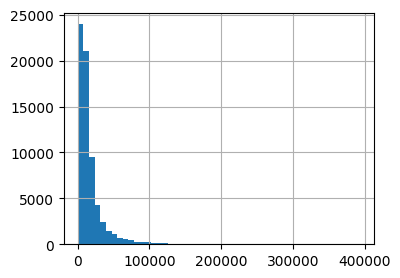

In [447]:
df_train.loan_amount.hist(bins=50, figsize=(4, 3))

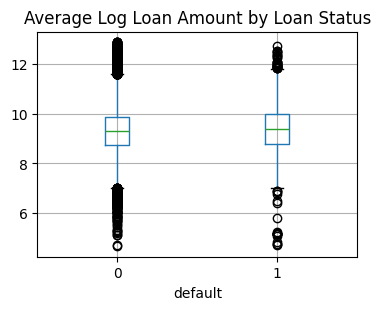

In [449]:
df_train['log_loan_amount'] = np.log1p(df_train['loan_amount'])

df_train.boxplot(column='log_loan_amount', by='default', figsize=(4, 3))
plt.title('Average Log Loan Amount by Loan Status')
plt.suptitle('') 
plt.show()

del df_train['log_loan_amount']


<Axes: >

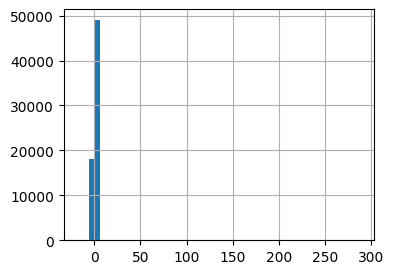

In [459]:
df_train.loan_to_debt_ratio.hist(bins=50, figsize=(4, 3))

In [460]:
df_train.loan_to_debt_ratio.describe()

count    67140.000000
mean         0.765344
std          1.158113
min        -17.864301
25%          0.394090
50%          1.000000
75%          1.000000
max        287.272727
Name: loan_to_debt_ratio, dtype: float64

<Axes: >

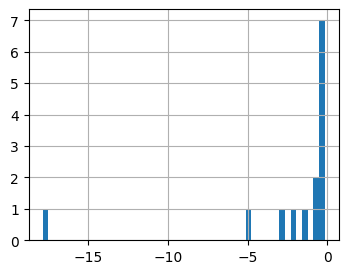

In [464]:
df_train.loan_to_debt_ratio[df_train.loan_to_debt_ratio < 0].hist(bins=50, figsize=(4, 3))

<Axes: >

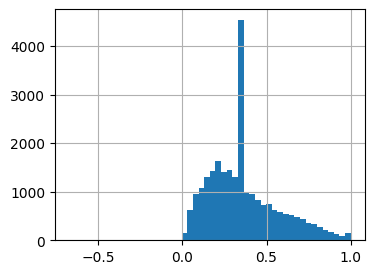

In [463]:
df_train.loan_to_debt_ratio[abs(df_train.loan_to_debt_ratio) < 1].hist(bins=50, figsize=(4, 3))

In [473]:
df_train.loan_to_debt_ratio[df_train.loan_to_debt_ratio > 2].count()

np.int64(7)

In [481]:
df_train[['loan_to_debt_ratio', 'loan_amount', 'existing_klarna_debt', 'default']][df_train.loan_to_debt_ratio > 2].T.round(2)

,2429,6810,12195,12497,19797,48170,65196
loan_to_debt_ratio,6.83,2.48,287.27,2.6,2.27,2.67,2.32
loan_amount,48300.00,25011.00,12640.00,2951.0,5285.00,7622.00,2552.00
existing_klarna_debt,-41232.00,-14924.00,-12596.00,-1816.0,-2952.00,-4762.00,-1452.00
default,0.00,0.00,0.00,0.0,0.00,1.00,1.00


Value counts for Loan-to-Debt Ratio bins:
loan_to_debt_ratio_binned
Medium    44967
Low       22156
High         17
Name: count, dtype: int64


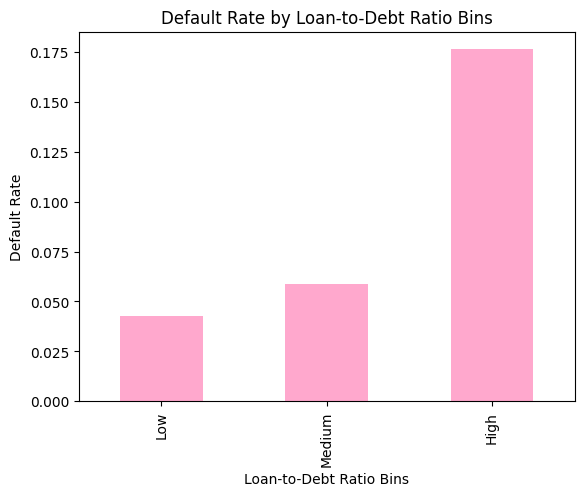

In [489]:
# Calculate custom percentiles
percentiles = np.percentile(df_train['loan_to_debt_ratio'], [0, 33, 66, 100])

# Perform binning based on these percentiles
df_train['loan_to_debt_ratio_binned'] = pd.cut(
    df_train['loan_to_debt_ratio'], 
    bins=percentiles, 
    labels=['Low', 'Medium', 'High'], 
    include_lowest=True
)

# Check the bin counts
print("Value counts for Loan-to-Debt Ratio bins:")
print(df_train['loan_to_debt_ratio_binned'].value_counts())

# Plot the default rate by bins
default_rate = df_train.groupby('loan_to_debt_ratio_binned', observed=True)['default'].mean()
default_rate.plot(kind='bar', color='#FFA8CD')
plt.title('Default Rate by Loan-to-Debt Ratio Bins')
plt.ylabel('Default Rate')
plt.xlabel('Loan-to-Debt Ratio Bins')
plt.show()


Explore card expiration

<Axes: >

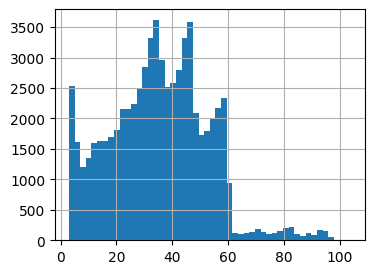

In [499]:
df_train.months_to_card_expiration.hist(bins=50, figsize=(4, 3))

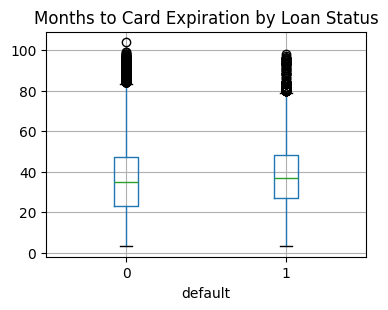

In [500]:
# Boxplot
df_train.boxplot(column='months_to_card_expiration', by='default', figsize=(4, 3))
plt.title('Months to Card Expiration by Loan Status')
plt.suptitle('')
plt.show()

Existing debt

In [501]:
df_train.existing_debt_missing.value_counts()

existing_debt_missing
0    49656
1    17484
Name: count, dtype: int64

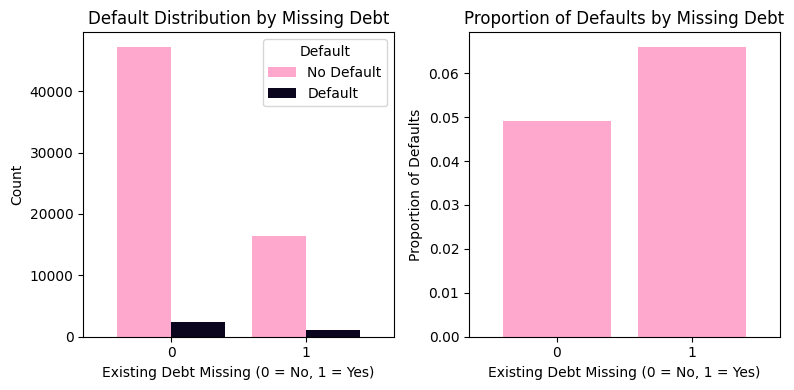

In [512]:
import matplotlib.pyplot as plt

# Calculate the counts for each group
counts = df_train.groupby(['existing_debt_missing', 'default']).size().unstack()

# Calculate proportions
proportions = df_train.groupby('existing_debt_missing')['default'].mean()

# Create a figure with two smaller subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4), sharey=False)

# Plot the grouped bar chart
counts.plot(kind='bar', color=['#FFA8CD', '#0B051D'], width=0.8, ax=axes[0])
axes[0].set_title('Default Distribution by Missing Debt')
axes[0].set_xlabel('Existing Debt Missing (0 = No, 1 = Yes)')
axes[0].set_ylabel('Count')
axes[0].legend(title='Default', labels=['No Default', 'Default'])
axes[0].tick_params(axis='x', rotation=0)

# Plot the proportion chart
proportions.plot(kind='bar', color='#FFA8CD', width=0.8, ax=axes[1])
axes[1].set_title('Proportion of Defaults by Missing Debt')
axes[1].set_xlabel('Existing Debt Missing (0 = No, 1 = Yes)')
axes[1].set_ylabel('Proportion of Defaults')
axes[1].tick_params(axis='x', rotation=0)

# Adjust layout
plt.tight_layout()
plt.show()


<Axes: >

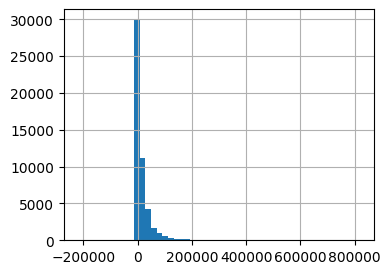

In [504]:
df_train.existing_klarna_debt[df_train.existing_debt_missing == False].hist(bins=50, figsize=(4, 3))

Explore num_active_loans

Explore days_since_first_loan

Explore new_exposure

Explore number of payments

Explore amount_repaid variables

In [490]:
amounts_repaid = [col for col in df_train.columns if 'amount_repaid' in col]
amounts_repaid

['amount_repaid_14d',
 'amount_repaid_1m',
 'amount_repaid_3m',
 'amount_repaid_6m',
 'amount_repaid_1y']

In [491]:
df_train[amounts_repaid].describe().round(2)

,amount_repaid_14d,amount_repaid_1m,amount_repaid_3m,amount_repaid_6m,amount_repaid_1y
count,67140.00,67140.00,67140.0,67140.00,67140.00
mean,2575.88,5157.01,13608.6,23738.68,38971.24
std,6621.67,12468.08,29922.4,51952.53,86685.22
min,0.00,0.00,0.0,0.00,0.00
25%,0.00,0.00,0.0,0.00,0.00
50%,0.00,0.00,0.0,3762.50,8481.50
75%,2479.50,5406.00,15001.0,26495.00,43295.25
max,214994.00,442293.00,736536.0,3582917.00,6985861.00


In [492]:
# how many zeros in each column?
df_train[amounts_repaid].apply(lambda x: (x == 0).sum())

amount_repaid_14d    43784
amount_repaid_1m     40347
amount_repaid_3m     34503
amount_repaid_6m     30679
amount_repaid_1y     27339
dtype: int64

In [495]:
repaiment_ratios = [col for col in df_train.columns if 'repay' in col]
repaiment_ratios

['repayment_1y_to_debt',
 'repayment_6m_to_debt',
 'repayment_3m_to_debt',
 'repayment_1m_to_debt',
 'repayment_14d_to_debt',
 'repayment_consistency',
 'repayment_rate_to_new_14d',
 'repayment_rate_to_num']

Value counts for repayment_1y_to_debt bins:
repayment_1y_to_debt_binned
Low       27351
High      22828
Medium    16961
Name: count, dtype: int64


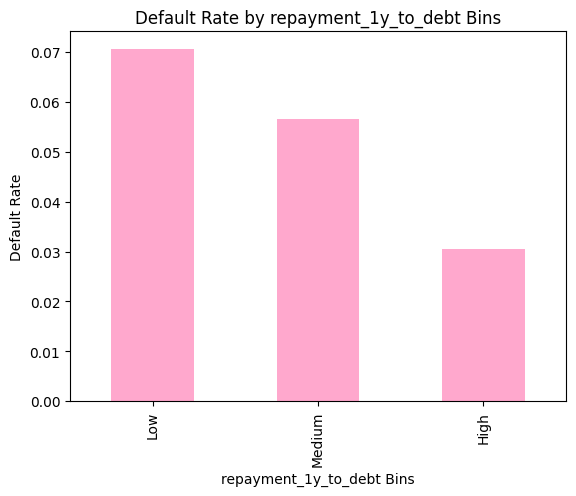

In [498]:
# Calculate custom percentiles
percentiles = np.percentile(df_train['repayment_1y_to_debt'], [0, 33, 66, 100])

# Perform binning based on these percentiles
df_train['repayment_1y_to_debt_binned'] = pd.cut(
    df_train['repayment_1y_to_debt'], 
    bins=percentiles, 
    labels=['Low', 'Medium', 'High'], 
    include_lowest=True
)

# Check the bin counts
print("Value counts for repayment_1y_to_debt bins:")
print(df_train['repayment_1y_to_debt_binned'].value_counts())

# Plot the default rate by bins
default_rate = df_train.groupby('repayment_1y_to_debt_binned', observed=True)['default'].mean()
default_rate.plot(kind='bar', color='#FFA8CD')
plt.title('Default Rate by repayment_1y_to_debt Bins')
plt.ylabel('Default Rate')
plt.xlabel('repayment_1y_to_debt Bins')
plt.show()


In [493]:
# Existing Klarna Debt
df_train.existing_klarna_debt.describe()

count     67140.000000
mean      11763.929178
std       29375.611077
min     -220618.000000
25%           0.000000
50%           0.000000
75%       11632.000000
max      817852.000000
Name: existing_klarna_debt, dtype: float64

In [ ]:
df_train[df_train.existing_klarna_debt<0].sample(5)

In [ ]:
# Existing Klarna Debt
df_train.boxplot(column = ['existing_klarna_debt'], by = 'default')
plt.title('Average existing_klarna_debt by Loan Status')
plt.suptitle('')
plt.show()

In [ ]:
# Number active loans
#df_train.num_active_loans.hist(bins=20, figsize=(4, 3))

df_train.num_active_loans.value_counts()

In [ ]:
# Days since first loan
df_train.days_since_first_loan.value_counts()

In [ ]:
# new_exposure_7d
df_train.boxplot(column = ['new_exposure_7d'], by = 'default')
plt.title('Average new_exposure_7d by Loan Status')
plt.suptitle('')
plt.show()

In [ ]:
# new_exposure_7d
df_train.boxplot(column = ['new_exposure_14d'], by = 'default')
plt.title('Average new_exposure_14d by Loan Status')
plt.suptitle('')
plt.show()

Explore number of payments

In [ ]:
df_train.num_failed_payments_3m.value_counts()

In [ ]:
df_train.num_confirmed_payments_6m.value_counts()

In [ ]:
df_train['failed_to_confirmed_ratio_6m'] = df_train['num_failed_payments_6m']/ (df_train['num_confirmed_payments_6m'] + 0.00001)


In [ ]:
df_train['failed_to_confirmed_ratio_6m'].describe()

In [ ]:
df_train.num_active_loans.value_counts()

In [74]:
df_train['failed_to_confirmed_ratio_6m'] = df_train['num_failed_payments_6m']/ (df_train['num_active_loans'] + 0.00001) 


Explore repayments

In [79]:
    # Repayment acceleration
df_train['repayment_acceleration'] = df_train['amount_repaid_14d'] - df_train['amount_repaid_1y']

    # Repayment consistency
df_train['repayment_consistency'] = df_train[['amount_repaid_14d', 'amount_repaid_1m', 'amount_repaid_3m', 'amount_repaid_6m', 'amount_repaid_1y']].std(axis=1)


In [ ]:
df_train['repayment_acceleration'].describe()

In [ ]:
df_train['repayment_acceleration'].hist(bins=50, figsize=(4, 3))

In [ ]:
df_train['repayment_consistency'].describe()

Inspect missing values

In [ ]:
df_train.isna().sum()

In [ ]:
df_train.existing_klarna_debt.describe()

In [ ]:
df_train[df_train.existing_klarna_debt.isna()].head()

In [ ]:
df_train.columns

# Feature selection

Feature selection - identify highly correlated features and drop to avoid multicollinearity. 

In [ ]:
# Compute the correlation matrix
corr_matrix = df_train[numerical_features_eda].corr()

# Select the upper triangle of the correlation matrix
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Plot the upper triangle of the correlation matrix
plt.figure(figsize=(12, 10))
#sns.heatmap(upper_triangle, annot=True, cmap="coolwarm", vmin=-1, vmax=1, mask=upper_triangle.isnull())
sns.heatmap(
    upper_triangle, 
    annot=True, 
    fmt=".2f",  # Format decimals to 2 places
    cmap="coolwarm", 
    vmin=-1, 
    vmax=1, 
    mask=upper_triangle.isnull(), 
    annot_kws={"size": 8},  # Annotation font size
    cbar_kws={'label': 'Correlation Coefficient'}  # Label for the color bar
)
plt.title("Upper Triangle of Correlation Matrix")
plt.show()


In [ ]:

# Set the correlation threshold
threshold = 0.95

# Find index of features with correlation greater than the threshold
to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column].abs() > threshold)]

print(f'There are {len(to_drop)} columns to remove:')
print(to_drop)

Finalize list of features

In [ ]:
# Remove from the list of features as needed
numerical_features = [
    feature for feature in numerical_features_eda 
    if feature not in to_drop 
    #and feature not in helper_columns
]

# Remove from the list of features as needed
categorical_features = categorical_features_eda 


# Print numerical features as a vertical list
print("\nNumerical features to use in training:\n")
print("\n".join(numerical_features))

# Print categorical features as a vertical list
print("\nCategorical features to use in training:\n")
print("\n".join(categorical_features))



In [1328]:

# Assert that 'default' is not in numerical_features
assert 'default' not in numerical_features, "'default' is still in numerical_features!"


In [ ]:
# Get all columns in df_train
all_columns = set(df_train.columns)

# Combine numerical_features and categorical_features
selected_features = set(numerical_features + categorical_features)

# Find columns that are not in either list
not_in_training = all_columns - selected_features

# Print the result
print("\nColumns not included in training:\n")
print("\n".join(sorted(not_in_training)))



In [ ]:
df_train[df['repayment_1y_to_debt'], df['repayment_acceleration'],  df['loan_to_debt_ratio'], df['card_expiry_missing'], df['new_exposure_7d_to_debt'],  df['repayment_6m_to_debt'], df['repayment_14d_to_debt'], ]

In [ ]:
df_train['repayment_1y_to_debt'].describe()

In [ ]:
# List of features to plot
features_to_plot = ['repayment_1y_to_debt', 'loan_to_debt_ratio', 'new_exposure_7d_to_debt', 'repayment_6m_to_debt', 'repayment_14d_to_debt']

# Loop over each feature
for feature in features_to_plot:
    # Calculate percentiles 
    percentiles = np.percentile(df_train[feature].dropna(), [0, 25, 50, 75, 100])

    # Binning the variable into 4 bins based on percentiles
    binned_col = f"{feature}_binned"
    df_train[binned_col] = pd.cut(
        df_train[feature],
        bins=percentiles,
        #labels=['Low', 'Medium', 'High', 'Very High'],
        include_lowest=True,
        duplicates='drop'
    )

    # Check bin counts
    print(f"Value counts for {feature} bins:")
    print(df_train[binned_col].value_counts())

    # Calculate default rate by bins
    default_rate = df_train.groupby(binned_col)['default'].mean()

    # Plot default rate by bins
    plt.figure(figsize=(4, 3))
    default_rate.plot(kind='bar', color='#FFA8CD')
    plt.title(f'Default Rate by {feature.replace("_", " ").capitalize()} Bins')
    plt.ylabel('Default Rate')
    plt.xlabel(f'{feature.replace("_", " ").capitalize()} Bins')
    plt.show()
